## Implementing ViT Model for CIFAR-10 from Scratch

### Step 1:
Define the ViT Model We will define the ViT model as described previously, but we will tailor it specifically for the CIFAR-10 dataset. CIFAR-10 images are of size 32 × 32 32×32, so we will adjust the patch size and positional encoding accordingly.

### Step 2: Prepare the CIFAR-10 Dataset
We'll use PyTorch's torchvision package to load and preprocess the CIFAR-10 dataset.

### Step 3: Train the ViT Model
We'll implement a training loop to train the ViT model on CIFAR-10 and evaluate it using the top-1 accuracy metric.

### Step 4: Experiment with Hyperparameters
We'll run experiments by changing various hyperparameters (e.g., embed_dim, mlp_dim, patch_size, heads, layers) and compare their performance.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(Attention, self).__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert self.head_dim * heads == embed_dim, "Embedding dimension must be divisible by heads"

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, inp):
        batch_size, seq_len, embed_dim = inp.size()

        # Step 1: Compute Q, K, V
        Q = self.W_Q(inp)  # (batch_size, seq_len, embed_dim)
        K = self.W_K(inp)  # (batch_size, seq_len, embed_dim)
        V = self.W_V(inp)  # (batch_size, seq_len, embed_dim)

        # Step 2: Reshape Q, K, V and permute
        Q = Q.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        V = V.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)

        # Step 3: Compute attention
        energy = torch.einsum("bhqd, bhkd -> bhqk", Q, K)  # (batch_size, heads, seq_len, seq_len)
        scaling_factor = self.head_dim ** 0.5
        attention = F.softmax(energy / scaling_factor, dim=-1)  # (batch_size, heads, seq_len, seq_len)

        # Step 4: Compute output
        out = torch.einsum("bhqk, bhvd -> bhqd", attention, V)  # (batch_size, heads, seq_len, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, heads, head_dim)
        out = out.view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)

        out = self.fc_out(out)  # (batch_size, seq_len, embed_dim)
        return out

In [3]:
import torch
import torch.nn as nn

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert self.head_dim * heads == embed_dim, "Embedding dimension must be divisible by heads"

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, inp):
        batch_size, seq_len, embed_dim = inp.size()

        Q = self.W_Q(inp)  # (batch_size, seq_len, embed_dim)
        K = self.W_K(inp)  # (batch_size, seq_len, embed_dim)
        V = self.W_V(inp)  # (batch_size, seq_len, embed_dim)

        Q = Q.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        V = V.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)

        energy = torch.einsum("bhqd, bhkd -> bhqk", Q, K)  # (batch_size, heads, seq_len, seq_len)
        scaling_factor = self.head_dim ** 0.5
        attention = torch.nn.functional.softmax(energy / scaling_factor, dim=-1)  # (batch_size, heads, seq_len, seq_len)

        out = torch.einsum("bhqk, bhvd -> bhqd", attention, V)  # (batch_size, heads, seq_len, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, heads, head_dim)
        out = out.view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)

        out = self.fc_out(out)  # (batch_size, seq_len, embed_dim)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiheadAttention(embed_dim, heads)
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.activation = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        attn_output = self.attention(inp)  # Apply multi-head attention
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inp + attn_output)  # Residual connection + LayerNorm

        ff_output = self.fc2(self.dropout2(self.activation(self.fc1(out1))))  # Feed-forward network
        out2 = self.norm2(out1 + ff_output)  # Residual connection + LayerNorm

        return out2

In [4]:
import torch
import torch.nn as nn

class Transformer(nn.Module):
    '''
    Transformer combines multiple layers of Transformer Blocks in a sequential manner.
    The sequence of operations is as follows:
    Input -> TB1 -> TB2 -> .......... -> TBn (n being the number of layers) -> Output

    Args:
    embed_dim: Dimension size of the hidden embedding in the TransformerBlock
    mlp_dim: Dimension size of MLP layer in the TransformerBlock
    layers: Number of Transformer Blocks in the Transformer
    heads: Number of parallel attention heads (Default=8)
    dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
    forward(inp) :-
    Applies the sequence of operations mentioned above.
    (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, embed_dim)

    Examples:
    >>> transformer = Transformer(embed_dim, mlp_dim, layers, heads, dropout)
    >>> out = transformer(inp)
    '''
    def __init__(self, embed_dim, mlp_dim, layers, heads=8, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, mlp_dim, heads, dropout) for _ in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        out = inp
        for trans_block in self.trans_blocks:
            out = trans_block(out)
        return out


In [5]:
import torch
import torch.nn as nn

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, num_classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (batch_size, embed_dim, num_patches ** 0.5, num_patches ** 0.5)
        x = x.flatten(2)  # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (batch_size, num_patches, embed_dim)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, num_patches):
        super(PositionalEncoding, self).__init__()
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))

    def forward(self, x):
        return x + self.pos_embedding

class MultiheadAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super(MultiheadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads

        assert self.head_dim * heads == embed_dim, "Embedding dimension must be divisible by heads"

        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, inp):
        batch_size, seq_len, embed_dim = inp.size()

        Q = self.W_Q(inp)  # (batch_size, seq_len, embed_dim)
        K = self.W_K(inp)  # (batch_size, seq_len, embed_dim)
        V = self.W_V(inp)  # (batch_size, seq_len, embed_dim)

        Q = Q.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        K = K.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)
        V = V.view(batch_size, seq_len, self.heads, self.head_dim).permute(0, 2, 1, 3)  # (batch_size, heads, seq_len, head_dim)

        energy = torch.einsum("bhqd, bhkd -> bhqk", Q, K)  # (batch_size, heads, seq_len, seq_len)
        scaling_factor = self.head_dim ** 0.5
        attention = torch.nn.functional.softmax(energy / scaling_factor, dim=-1)  # (batch_size, heads, seq_len, seq_len)

        out = torch.einsum("bhqk, bhvd -> bhqd", attention, V)  # (batch_size, heads, seq_len, head_dim)
        out = out.permute(0, 2, 1, 3).contiguous()  # (batch_size, seq_len, heads, head_dim)
        out = out.view(batch_size, seq_len, embed_dim)  # (batch_size, seq_len, embed_dim)

        out = self.fc_out(out)  # (batch_size, seq_len, embed_dim)
        return out

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, mlp_dim, heads, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiheadAttention(embed_dim, heads)
        self.fc1 = nn.Linear(embed_dim, mlp_dim)
        self.fc2 = nn.Linear(mlp_dim, embed_dim)
        self.activation = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        attn_output = self.attention(inp)  # Apply multi-head attention
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(inp + attn_output)  # Residual connection + LayerNorm

        ff_output = self.fc2(self.dropout2(self.activation(self.fc1(out1))))  # Feed-forward network
        out2 = self.norm2(out1 + ff_output)  # Residual connection + LayerNorm

        return out2

class ClassificationHead(nn.Module):
    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        x = self.fc1(inp)  # (batch_size, embed_dim // 2)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.fc2(x)  # (batch_size, classes)
        x = self.softmax(x)
        return x

class VisionTransformer(nn.Module):
    '''
    Vision Transformer is the complete end-to-end model architecture that
    combines all the above modules in a sequential manner. The sequence of the
    operations is as follows -

    Args:
    patch_size: Length of square patch size
    max_len: Max length of learnable positional embedding
    embed_dim: Dimension size of the hidden embedding
    mlp_dim: Dimension size of MLP embedding
    classes: Number of classes in the dataset
    layers: Number of Transformer Blocks in the Transformer
    channels: Number of channels in the input (Default=3)
    heads: Number of parallel attention heads (Default=8)
    dropout: Dropout value for the layer on attention_scores (Default=0.1)

    Methods:
    forward(inp) :-
    Applies the sequence of operations mentioned above.
    It outputs the classification output as well as the sequence output of
    the transformer
    (batch_size, channels, width, height) -> (batch_size, classes),
    (batch_size, seq_len+1, embed_dim)

    Examples:
    >>> ViT = VisionTransformer(inp_channels, patch_size, max_len, heads,
    classes, layers, embed_dim, mlp_dim, channels, dropout)
    >>> class_out, hidden_seq = ViT(inp)
    '''
    def __init__(self, patch_size, max_len, embed_dim, mlp_dim, classes, layers, channels=3, heads=8, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size=max_len, patch_size=patch_size, in_channels=channels, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = PositionalEncoding(embed_dim, self.patch_embed.num_patches)
        self.pos_drop = nn.Dropout(p=dropout)
        self.transformer = Transformer(embed_dim, mlp_dim, layers, heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = ClassificationHead(embed_dim, classes, dropout)

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size = inp.size(0)
        x = self.patch_embed(inp)  # (batch_size, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        x = self.pos_embed(x)  # Add positional encoding
        x = self.pos_drop(x)
        x = self.transformer(x)  # (batch_size, num_patches + 1, embed_dim)
        x = self.norm(x)
        cls_output = x[:, 0]  # Extract the classification token
        class_out = self.head(cls_output)  # (batch_size, classes)
        return class_out, x

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, patch_size, max_len, embed_dim, mlp_dim, classes, layers, channels=3, heads=8, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size=max_len, patch_size=patch_size, in_channels=channels, embed_dim=embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = PositionalEncoding(embed_dim, self.patch_embed.num_patches)
        self.pos_drop = nn.Dropout(p=dropout)
        self.transformer = Transformer(embed_dim, mlp_dim, layers, heads, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = ClassificationHead(embed_dim, classes, dropout)

    def forward(self, inp):
        batch_size = inp.size(0)
        x = self.patch_embed(inp)  # (batch_size, num_patches, embed_dim)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (batch_size, 1, embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        x = self.pos_embed(x)  # Add positional encoding
        x = self.pos_drop(x)
        x = self.transformer(x)  # (batch_size, num_patches + 1, embed_dim)
        x = self.norm(x)
        cls_output = x[:, 0]  # Extract the classification token
        class_out = self.head(cls_output)  # (batch_size, classes)
        return class_out, x

In [8]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:14<00:00, 11533597.38it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [9]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    best_acc = 0.0

    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs, _ = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_accuracies.append(val_acc)
        print(f'Validation Accuracy: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return train_losses, train_accuracies, val_accuracies

In [10]:
# Experiment 1: Base Configuration
model = VisionTransformer(patch_size=4, max_len=32, embed_dim=128, mlp_dim=256, classes=10, layers=6, channels=3, heads=4, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Experiment 2: Increase embed_dim and mlp_dim
model = VisionTransformer(patch_size=4, max_len=32, embed_dim=256, mlp_dim=512, classes=10, layers=6, channels=3, heads=4, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Experiment 3: Increase number of heads and layers
model = VisionTransformer(patch_size=4, max_len=32, embed_dim=128, mlp_dim=256, classes=10, layers=12, channels=3, heads=8, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Experiment 4: Smaller patch size
model = VisionTransformer(patch_size=2, max_len=32, embed_dim=128, mlp_dim=256, classes=10, layers=6, channels=3, heads=4, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

Epoch [1/20], Loss: 2.2398, Accuracy: 0.1944
Validation Accuracy: 0.2003
Epoch [2/20], Loss: 2.2211, Accuracy: 0.2152
Validation Accuracy: 0.2103
Epoch [3/20], Loss: 2.2166, Accuracy: 0.2203
Validation Accuracy: 0.2440
Epoch [4/20], Loss: 2.2118, Accuracy: 0.2243
Validation Accuracy: 0.2172
Epoch [5/20], Loss: 2.2139, Accuracy: 0.2219
Validation Accuracy: 0.2405
Epoch [6/20], Loss: 2.2074, Accuracy: 0.2307
Validation Accuracy: 0.2401
Epoch [7/20], Loss: 2.2059, Accuracy: 0.2304
Validation Accuracy: 0.2393
Epoch [8/20], Loss: 2.2058, Accuracy: 0.2309
Validation Accuracy: 0.2286
Epoch [9/20], Loss: 2.2045, Accuracy: 0.2337
Validation Accuracy: 0.2462
Epoch [10/20], Loss: 2.2098, Accuracy: 0.2272
Validation Accuracy: 0.2363
Epoch [11/20], Loss: 2.2025, Accuracy: 0.2368
Validation Accuracy: 0.2423
Epoch [12/20], Loss: 2.2025, Accuracy: 0.2357
Validation Accuracy: 0.2417
Epoch [13/20], Loss: 2.1995, Accuracy: 0.2388
Validation Accuracy: 0.2477
Epoch [14/20], Loss: 2.2023, Accuracy: 0.2396
V

([2.236222783126831,
  2.2215712019348146,
  2.217932333984375,
  2.2197528656768797,
  2.2119880825805662,
  2.210557150115967,
  2.2105280078125,
  2.211612846298218,
  2.2077302027893064,
  2.2069537062072753,
  2.2086501564025878,
  2.2038171690368653,
  2.203787625656128,
  2.2011394234466555,
  2.20113176071167,
  2.2014627978515624,
  2.202002547073364,
  2.200169298019409,
  2.2004103563690185,
  2.1997682469940187],
 [0.19568,
  0.2123,
  0.2176,
  0.21676,
  0.22458,
  0.227,
  0.22598,
  0.22488,
  0.22772,
  0.23078,
  0.2292,
  0.23516,
  0.2348,
  0.23828,
  0.23592,
  0.23846,
  0.23696,
  0.23866,
  0.24048,
  0.24254],
 [0.2291,
  0.2309,
  0.2273,
  0.2224,
  0.2385,
  0.2349,
  0.2382,
  0.2336,
  0.2329,
  0.2399,
  0.2431,
  0.2328,
  0.2471,
  0.2371,
  0.2431,
  0.2441,
  0.2431,
  0.2533,
  0.2532,
  0.2435])

Epoch [1/20], Loss: 2.2390, Accuracy: 0.1947
Validation Accuracy: 0.2160
Epoch [2/20], Loss: 2.2173, Accuracy: 0.2193
Validation Accuracy: 0.2234
Epoch [3/20], Loss: 2.2129, Accuracy: 0.2262
Validation Accuracy: 0.2337
Epoch [4/20], Loss: 2.2105, Accuracy: 0.2267
Validation Accuracy: 0.2270
Epoch [5/20], Loss: 2.2087, Accuracy: 0.2287
Validation Accuracy: 0.2245
Epoch [6/20], Loss: 2.2098, Accuracy: 0.2286
Validation Accuracy: 0.2429
Epoch [7/20], Loss: 2.2088, Accuracy: 0.2285
Validation Accuracy: 0.2337
Epoch [8/20], Loss: 2.2030, Accuracy: 0.2355
Validation Accuracy: 0.2448
Epoch [9/20], Loss: 2.2015, Accuracy: 0.2381
Validation Accuracy: 0.2458
Epoch [10/20], Loss: 2.2080, Accuracy: 0.2310
Validation Accuracy: 0.2363
Epoch [11/20], Loss: 2.2020, Accuracy: 0.2371
Validation Accuracy: 0.2348
Epoch [12/20], Loss: 2.2043, Accuracy: 0.2346
Validation Accuracy: 0.2378
Epoch [13/20], Loss: 2.2032, Accuracy: 0.2345
Validation Accuracy: 0.2365
Epoch [14/20], Loss: 2.2038, Accuracy: 0.2372
V

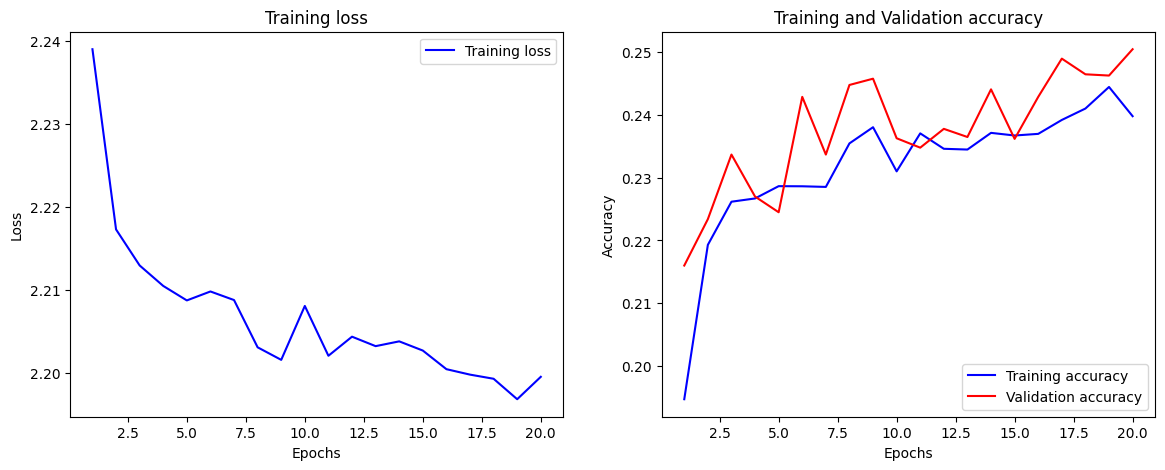

In [11]:
# Define your model, criterion, and optimizer as usual
model = VisionTransformer(patch_size=4, max_len=32, embed_dim=128, mlp_dim=256, classes=10, layers=6, channels=3, heads=4, dropout=0.1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

# Train the model and get the loss and accuracy values
train_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=20)

# Plotting the training loss and accuracies
epochs = range(1, 21)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [13]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
classes = test_dataset.classes

Files already downloaded and verified


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (use the same parameters as the best model configuration)
model = VisionTransformer(patch_size=4, max_len=32, embed_dim=128, mlp_dim=256, classes=10, layers=6, channels=3, heads=4, dropout=0.1)
model.load_state_dict(torch.load('best_vit_model.pth'))
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
  )
  (pos_embed): PositionalEncoding()
  (pos_drop): Dropout(p=0.1, inplace=False)
  (transformer): Transformer(
    (trans_blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiheadAttention(
          (W_Q): Linear(in_features=128, out_features=128, bias=True)
          (W_K): Linear(in_features=128, out_features=128, bias=True)
          (W_V): Linear(in_features=128, out_features=128, bias=True)
          (fc_out): Linear(in_features=128, out_features=128, bias=True)
        )
        (fc1): Linear(in_features=128, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=128, bias=True)
        (activation): GELU(approximate='none')
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): 

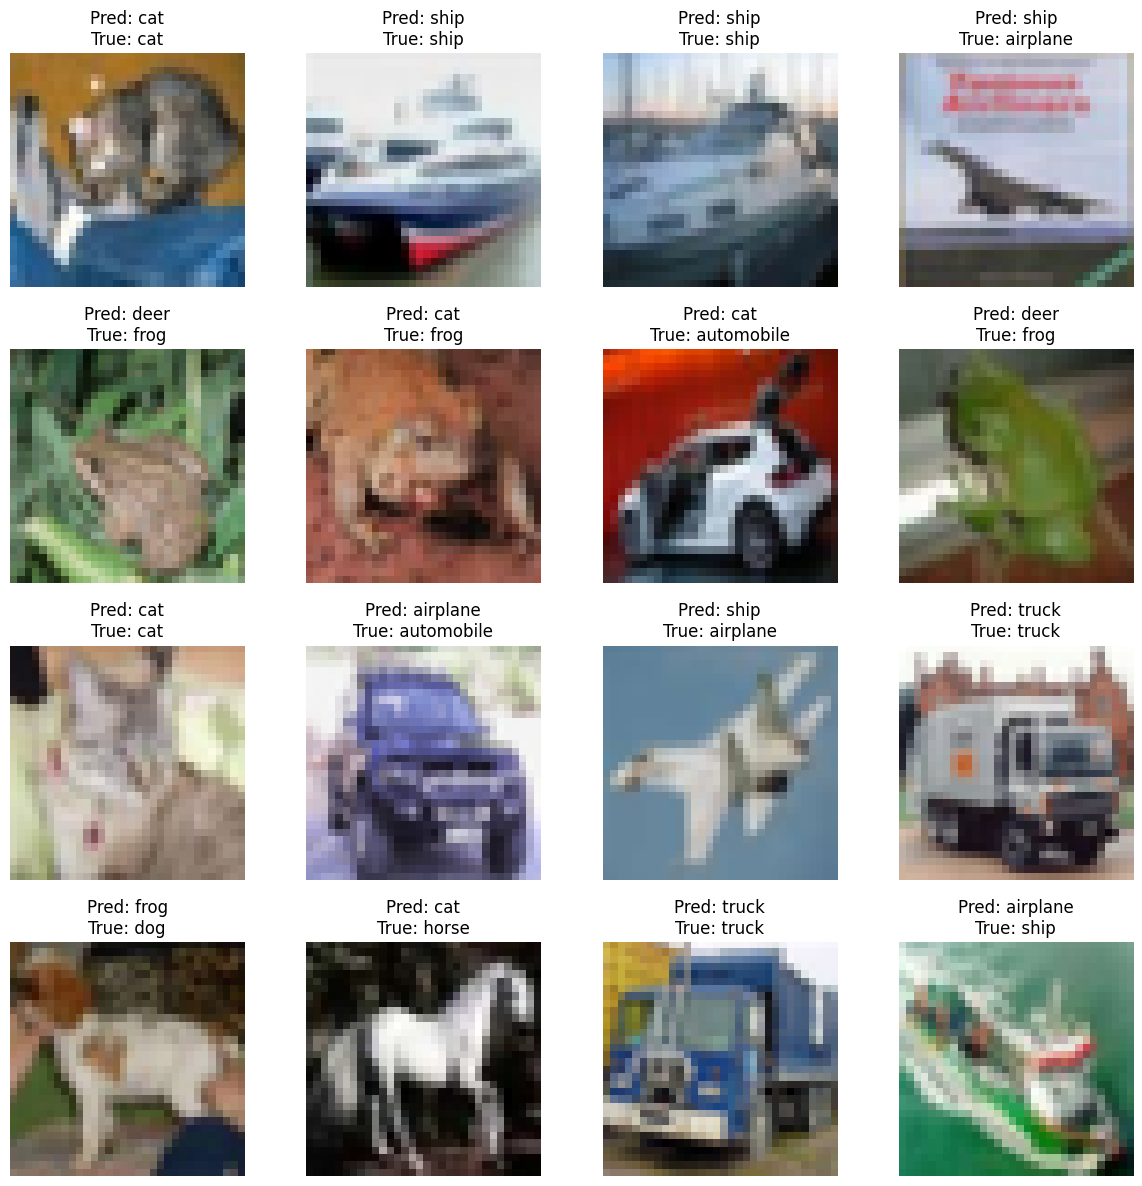

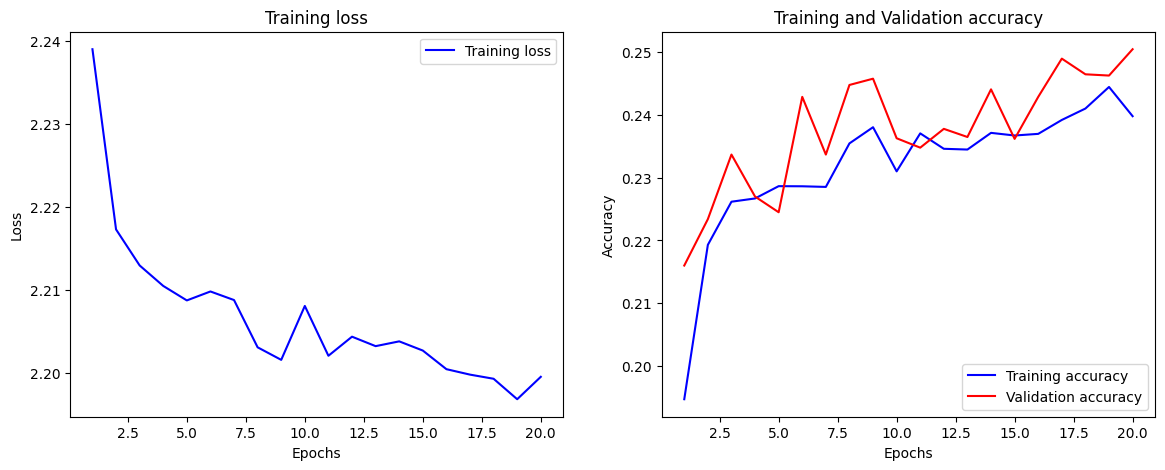

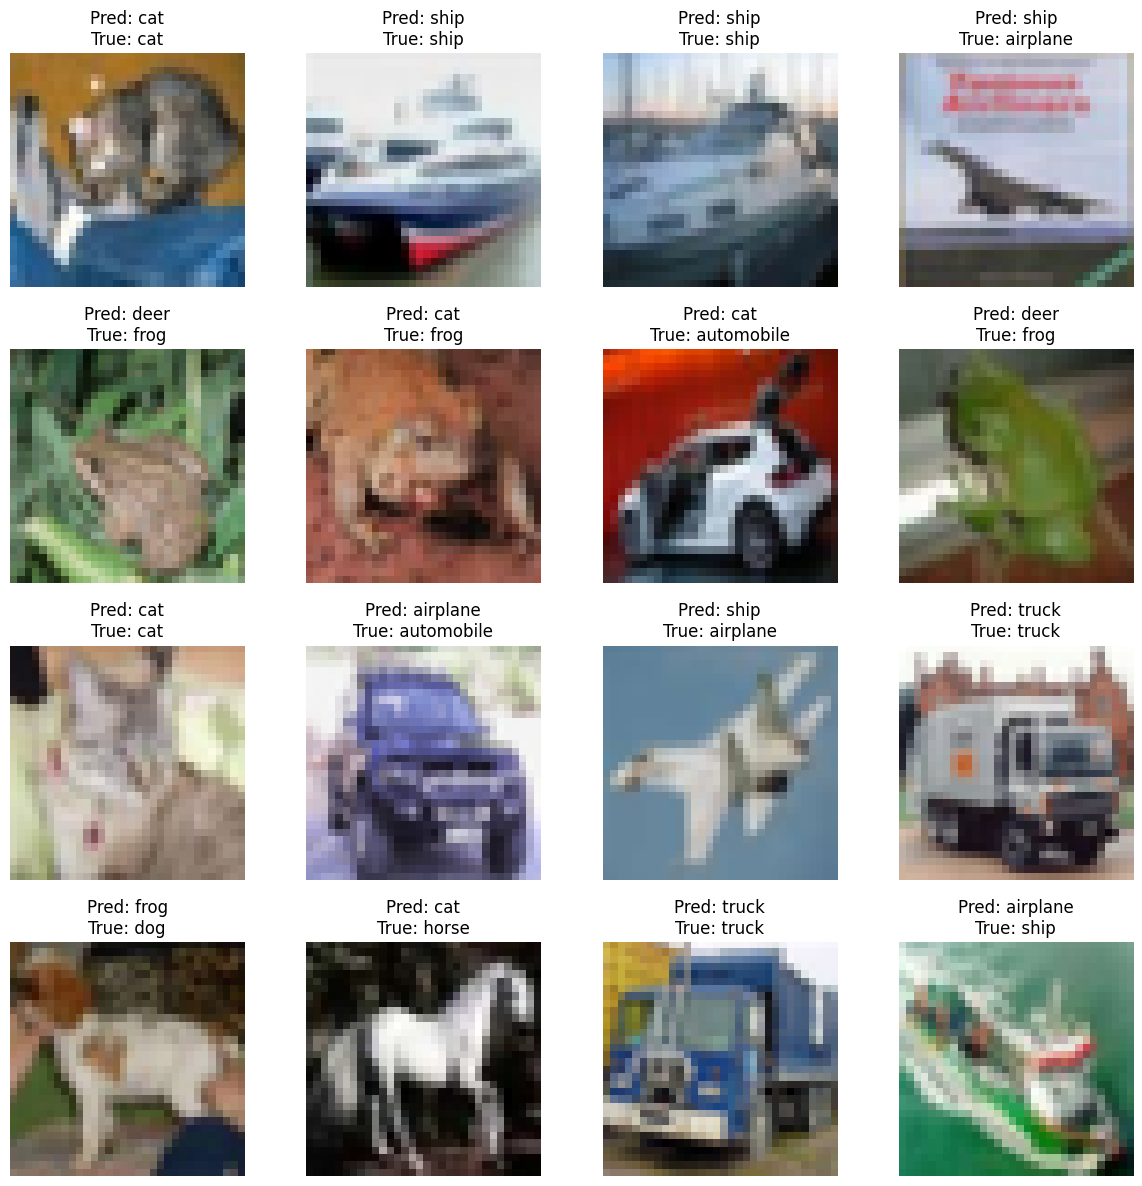

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict
outputs, _ = model(images)# Predict and Visualize Results
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predict
outputs, _ = model(images)
_, predicted = torch.max(outputs, 1)

# Show images and predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    img = images[i].cpu()
    label = labels[i].cpu()
    pred = predicted[i].cpu()
    ax.imshow(np.transpose(img.numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(f'Pred: {classes[pred]}\nTrue: {classes[label]}')
    ax.axis('off')

plt.show()

# Plotting the training loss and accuracies
epochs = range(1, 21)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
_, predicted = torch.max(outputs, 1)

# Show images and predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.tight_layout()

for i, ax in enumerate(axes.flat):
    img = images[i].cpu()
    label = labels[i].cpu()
    pred = predicted[i].cpu()
    ax.imshow(np.transpose(img.numpy() / 2 + 0.5, (1, 2, 0)))
    ax.set_title(f'Pred: {classes[pred]}\nTrue: {classes[label]}')
    ax.axis('off')

plt.show()